# Toy data generation prep

MJ Rose with Dan Marrone, 2018 

Data preparation for generating EHT time domain toy data for designing statistical tests

This notebook adjusts two given simulations (a 'hotspot' and a 'quiescent' flux simulation) for use in 1_walkthrough.ipynb

In [1]:
"""
EHT toy data generation
author: MJ Rose
email: mjrose@email.arizona.edu
website: https://github.com/meljrose
"""

'\nEHT toy data generation\nauthor: MJ Rose\nemail: mjrose@email.arizona.edu\nwebsite: https://github.com/meljrose\n'

In [1]:
from __future__ import division
from __future__ import print_function
import sys, io, os
import numpy as np
import scipy.ndimage as sciim
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import animation
import base64
from IPython.display import HTML
import h5py
import itertools
import copy
import pickle
sys.path.insert(0,'../../eht-imaging') # or wherever you've installed eht-imaging
import ehtim as eh

In [2]:
%matplotlib inline
# use seaborn for plot styles
#import seaborn; seaborn.set()

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from local_tools.generation import *

# trim/scale movies

In this notebook we trim, resize, and recenter the two simulations for later use

This simulation (../data/raw/Esim.h5) is Model E discussed in (<a href='https://arxiv.org/pdf/1610.03505.pdf'>Medeiros et al. 2016</a>).

In [3]:
# the hotspot is some generic model
sim = open_hdf5('../data/raw/Esim.h5')
hotspot = open_hdf5('../data/raw/hot_spot_only.h5')
print(np.shape(hotspot), np.shape(sim))

(128, 128, 128) (1024, 512, 512)


In [4]:
# lets make this combined movie in the shape (1024, 128, 128)
# we need to trim the hotspot movie so the cycles line up seamlessly
# here we pick a pixel to monitor
pixel = (63,53)

fig = plt.figure(figsize=(10,5))
fig.suptitle('monitoring pixel {0}'.format(pixel), size=20)
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
imag = ax1.imshow(hotspot[0])
ax1.scatter(*pixel, marker='.',c='r')
ax2.scatter(np.arange(128),hotspot[:,pixel[1], pixel[0]])
ax2.axhline(y=np.max(hotspot[:,pixel[1], pixel[0]]), linestyle='--')
line, = ax2.plot([], [], lw=2, c='k', linestyle='-', alpha=0.5)

def animate(i):
    x = i
    y = np.linspace(-0.02, 0.02, 100)
    line.set_data(x, y)
    imag.set_data(hotspot[i])
    return line,

anim = animation.FuncAnimation(fig, animate, frames=128, interval=100, blit=True)
peaks_arr = np.where(hotspot[:,pixel[1],pixel[0]] == np.max(hotspot[:,pixel[1],pixel[0]]))[0]
print('peaks at indices: ', peaks_arr)
plt.close()
HTML(anim.to_html5_video())

peaks at indices:  [ 19  69 119]


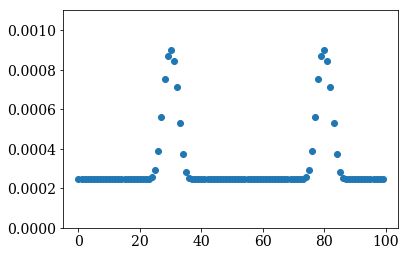

100


In [5]:
# lets line up index with the peaks
new_hotspot = np.roll(hotspot[peaks_arr[0]:peaks_arr[2],:,:], 30, axis=0)
# and scale the pixel values to 1
new_hotspot = scale_frames(1.0, new_hotspot)
plt.figure()
plt.scatter(np.arange(len(new_hotspot)),new_hotspot[:,pixel[1],pixel[0]])
plt.axhline(y=np.max(hotspot[:,pixel[1],pixel[0]]), linestyle='--')
plt.ylim(0., 0.0011)
plt.show()
print(len(new_hotspot))
# so one cycle is every 50 frames

In [6]:
# we want to be able to change the period of the hotspot
# we'll do this by interpolating up to the number of frames we need since our hotspot movie is well behaved
# rather than interpolate every time, let's save the spline-interpolation coefficients now & read them in as needed
pixel_arr = np.arange(np.shape(new_hotspot)[1])
x = np.arange(0, len(new_hotspot), 1.0)
pixel_dict = {}
for i in pixel_arr:
    for j in pixel_arr:
        y = new_hotspot[:,i, j]
        t, c, k =interpolate.splrep(x, y, k=3)
        pixel_dict[(i, j)] = (t,c,k)
        
with open('../data/interim/pixel_dict.pkl', 'wb') as f:
        pickle.dump(pixel_dict, f, pickle.HIGHEST_PROTOCOL)

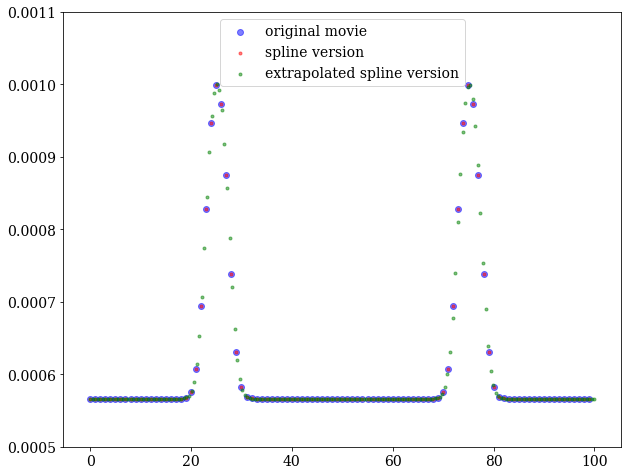

In [7]:
# check out the spline representation
# you can vary these parameters
n_frames = 200
duration = 100


pixel = (63,53)
t, c, k = pixel_dict[pixel]
spline = interpolate.BSpline(t, c, k, extrapolate='periodic')
plt.figure(figsize=(10,8))
x = np.arange(0, len(new_hotspot), 1.0)
y = new_hotspot[:,pixel[0], pixel[1]]
plt.scatter(x, y, marker='o', c='b', alpha=0.5, label='original movie')
plt.scatter(x, spline(x), c='r', marker='.', alpha=0.5, label='spline version')
xx = np.linspace(0,duration, n_frames)
plt.scatter(xx, spline(xx), c='g', marker='.', alpha=0.5, label='extrapolated spline version')
plt.legend()
plt.ylim(0.0005, 0.0011)
plt.show()

In [8]:
# let's see what the interpolated movie looks like
# all of these are in seconds
movie_duration =  6* 60 * 60 
hotspot_period1 = 30 * 60 
hotspot_period2 = 4 * 60 * 60 
hotspot_frames1 = generate_hotspot_frames(hotspot_period1, movie_duration)
hotspot_frames2 = generate_hotspot_frames(hotspot_period2, movie_duration)

generating 21600.00 sec movie at frame rate of 0.05 /sec
generating 21600.00 sec movie at frame rate of 0.05 /sec


In [32]:
# in these animations we speed up the movie by x1000
movie1 = hotspot_frames1
movie2 = hotspot_frames2


fig = plt.figure(figsize=(10,5))
fig.suptitle('Interpolated & Sampled Hotspot Movie Example', size=20)
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.set_title('{0:.2f} hr Period'.format(hotspot_period1/3600.))
ax2.set_title('{0:.2f} hr Period'.format(hotspot_period2/3600.))
imag1 = ax1.imshow(movie1[0], origin="lower")
imag2 = ax2.imshow(movie2[0], origin="lower")


annotation1 = ax1.annotate("", (0.6, 0.91), textcoords='axes fraction', size=20, weight = 'bold')
annotation1.set_animated(True)
annotation2 = ax2.annotate("", (0.6, 0.91), textcoords='axes fraction', size=20, weight = 'bold')
annotation2.set_animated(True)

def init():
    return annotation1, annotation2

def animate(i):
    try:
        imag1.set_data(movie1[i])
        annotation1._text = '{0:.2f} hrs'.format(i * movie_duration/1024./3600. )
    except:
        imag1.set_data(movie1[0])
    try:
        imag2.set_data(movie2[i])
        annotation2._text = '{0:.2f} hrs'.format(i * movie_duration/1024./3600. )
    except:
        imag2.set_data(movie2[0])
    return annotation1, annotation2

# interval is in milisecs 
anim = animation.FuncAnimation(fig, animate, frames=1024, interval=30)
plt.close()
HTML(anim.to_html5_video())


In [ ]:
# now the hotspot movie is prepped, let's move on to the simulation movie
# here, we resize & shift the higher resolution simulation movie to match the hotspot movie
# then we scale the pixel values to 1.0 and save
new_sim = make_lower_res(sim, (1024,128,128)) # this is a one-use function for this specific simulation
new_sim = scale_frames(1.0, new_sim)

if not os.path.exists('../data/interim/'):
    os.makedirs('../data/interim/')
hf = h5py.File('../data/interim/trimmed_sim.h5', 'w')
hf.create_dataset('sim', data=new_sim)
hf.close()

# generate_toy_data()

In [ ]:
# Runs through the walkthrough in a single function, if you need to generate many test cases. 
# Requires '../data/interim/pixel_dict.pkl' and '../data/interim/trimmed_sim.h5' 
help(generate_toy_data)

In [10]:
def quick_plot(filename):
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[5,5], height_ratios=[5])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    fig.tight_layout()
    st = fig.suptitle(filename)
    obs = eh.obsdata.load_uvfits(filename)
    ax1.scatter(obs.data['time'], np.abs(obs.data['vis']))
    ax1.set_ylabel('vis')
    ax1.set_xlabel('time')
    ax2.scatter(np.sqrt(obs.data['u']**2 + obs.data['v']**2), np.abs(obs.data['vis']),c='b', alpha=0.75, marker='.')
    ax2.set_ylabel('vis')
    ax2.set_xlabel('baseline')
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    plt.show()
    return(obs)

In [11]:
# load in and process vex file
vex = eh.io.load.load_vex('../data/raw/testa.vex') 
movie_duration = 10 * 60 * 60 # in seconds
continuous_vex = make_vex_continuous(vex)
scaled_continuous_vex = scale_vex_obstime(continuous_vex, movie_duration)


Loading vexfile:  ../data/raw/testa.vex


# data generation example

In [12]:
%%capture

folder = '../data/generated/'
main_directory = 'continuous_diff_periods_vexA/'
subdir = '0.1noise/'
pathname = folder+main_directory+subdir
if not os.path.exists(folder+main_directory):
    os.makedirs(folder+main_directory)
if not os.path.exists(pathname):
    os.makedirs(pathname)
    
noise_factor = 0.1
hotspot_offset = 0.0
hotspot_ratio = 0.5
mean_flux = 3.5
    
for period in np.geomspace(start=3, stop=60, num=10): # this gives geometrically spaced periods bw 3 min and 60 min
    f = pathname+'data_{0:.3f}min_{1:.2f}noise_{2:.2f}ratio.uvfits'.format(period, noise_factor, hotspot_ratio)
    generate_toy_data(scaled_continuous_vex, f, movie_duration, mean_flux, period*60, \
                  hotspot_ratio, hotspot_offset, noise_factor)
    
    f = pathname+'detrend_{0:.3f}min_{1:.2f}noise_{2:.2f}ratio.uvfits'.format(period, noise_factor, hotspot_ratio)
    generate_toy_data(scaled_continuous_vex, f, movie_duration, mean_flux,period*60, \
                  hotspot_ratio, hotspot_offset, noise_factor, constant_sim = True)
    
    f = pathname+'constant_{0:.3f}min_{1:.2f}noise_0.0ratio.uvfits'.format(period, noise_factor)
    generate_toy_data(scaled_continuous_vex, f, movie_duration, mean_flux,period*60, \
                  0.0, hotspot_offset, noise_factor, constant_sim = True)
    break # only do 1 loop for the example


Loading uvfits:  ../data/generated/continuous_diff_periods_vexA/0.1noise/data_3.000min_0.10noise_0.50ratio.uvfits
no IF in uvfits header!
Number of uvfits Correlation Products: 4
No NX table in uvfits!


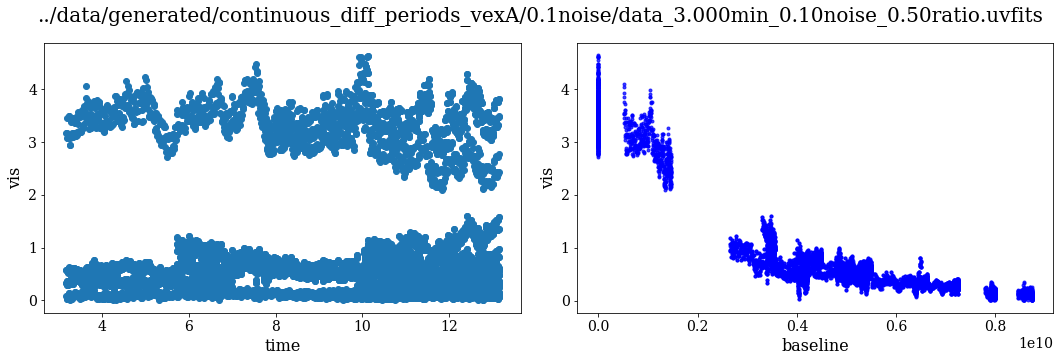


Loading uvfits:  ../data/generated/continuous_diff_periods_vexA/0.1noise/detrend_3.000min_0.10noise_0.50ratio.uvfits
no IF in uvfits header!
Number of uvfits Correlation Products: 4
No NX table in uvfits!


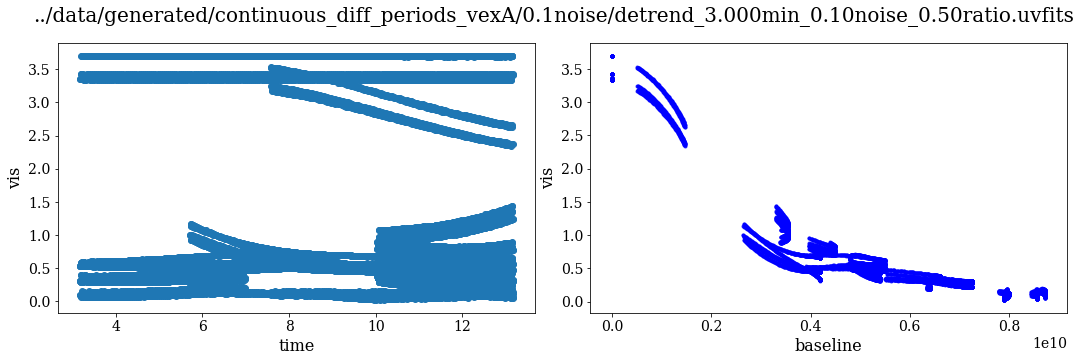


Loading uvfits:  ../data/generated/continuous_diff_periods_vexA/0.1noise/constant_3.000min_0.10noise_0.0ratio.uvfits
no IF in uvfits header!
Number of uvfits Correlation Products: 4
No NX table in uvfits!


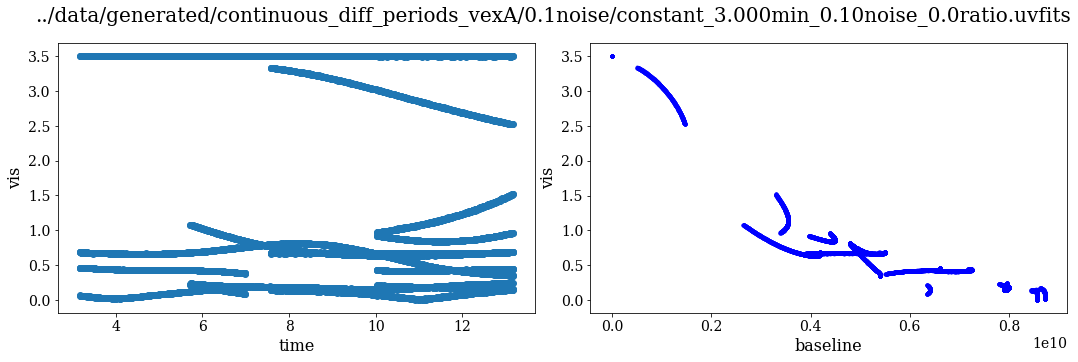

In [13]:
for period in np.geomspace(start=3, stop=60, num=10):
    f = pathname+'data_{0:.3f}min_{1:.2f}noise_{2:.2f}ratio.uvfits'.format(period, noise_factor, hotspot_ratio)
    quick_plot(f)
    
    f = pathname+'detrend_{0:.3f}min_{1:.2f}noise_{2:.2f}ratio.uvfits'.format(period, noise_factor, hotspot_ratio)
    quick_plot(f)
    
    f = pathname+'constant_{0:.3f}min_{1:.2f}noise_0.0ratio.uvfits'.format(period, noise_factor)
    quick_plot(f)
    
    break

# the observation object

In [16]:
# to work with the observation, you could use ehtim
f = pathname+'data_{0:.3f}min_{1:.2f}noise_{2:.2f}ratio.uvfits'.format(period, noise_factor, hotspot_ratio)
obs = eh.obsdata.load_uvfits(f)


Loading uvfits:  ../data/generated/continuous_diff_periods_vexA/0.1noise/data_3.000min_0.10noise_0.50ratio.uvfits
no IF in uvfits header!
Number of uvfits Correlation Products: 4
No NX table in uvfits!


Any easy way to see the contents of this object is to use vars()

In [17]:
vars(obs)

{'source': 'SgrA',
 'ra': 17.76112247222222,
 'dec': -28.99218944444445,
 'rf': 230000000000.0,
 'bw': 2048000000.0,
 'ampcal': True,
 'phasecal': True,
 'opacitycal': True,
 'dcal': True,
 'frcal': True,
 'timetype': 'UTC',
 'tarr': array([('ALMA',  2.22506116e+06, -5.44005737e+06, -2481681.15054,   100.,   100., 0.+0.j, 0.+0.j, 0., 0., 0.),
        ('APEX',  2.22503953e+06, -5.44119763e+06, -2479303.3597 ,  5600.,  5600., 0.+0.j, 0.+0.j, 0., 0., 0.),
        ('JCMT', -5.46458468e+06, -2.49300117e+06,  2150653.982  ,  9000.,  9000., 0.+0.j, 0.+0.j, 0., 0., 0.),
        ('LMT', -7.68715632e+05, -5.98850707e+06,  2063354.852  ,  3600.,  3600., 0.+0.j, 0.+0.j, 0., 0., 0.),
        ('PICOVEL',  5.08896775e+06, -3.01681186e+05,  3825012.20561,  2900.,  2900., 0.+0.j, 0.+0.j, 0., 0., 0.),
        ('SMAP', -5.46455549e+06, -2.49292799e+06,  2150797.176  ,  7800.,  7800., 0.+0.j, 0.+0.j, 0., 0., 0.),
        ('SMTO', -1.82879620e+06, -5.05440680e+06,  3427865.2    , 19000., 19000., 0.+0.j, 0.

you can look at visibilities

In [18]:
obs.data['vis'] 

array([ 3.1758728 -0.00181002j, -0.15986115-0.2831443j ,
       -0.16113034-0.28238374j, ..., -0.03220979+0.1160446j ,
       -0.04203559-0.0391847j ,  0.08972842+0.02939884j])

and calculate closure phase

In [19]:
cp_obs = obs.c_phases(mode='all', count='max',ang_unit='rad',vtype='vis') 

Getting bispectra:: type vis, count max, scan 1050/1050 
Reformatting bispectra to closure phase...


In [20]:
cp_obs

array([( 3.16666675, 'PICOVEL', 'ALMA', 'SPT',  3.56056320e+09, 5.57628314e+09, -4.38526208e+09, 3.11122432e+09,  8.24698816e+08, -8.68750746e+09,  0.18134851, 0.21932974),
       ( 3.16666675, 'PICOVEL', 'APEX', 'ALMA',  3.56142515e+09, 5.57475994e+09, -8.62018750e+05, 1.52295925e+06, -3.56056320e+09, -5.57628314e+09, -0.00511942, 0.03022978),
       ( 3.16666675, 'PICOVEL', 'APEX', 'SPT',  3.56142515e+09, 5.57475994e+09, -4.38612378e+09, 3.11274726e+09,  8.24698816e+08, -8.68750746e+09,  0.16922989, 0.22494192),
       ...,
       (13.15990448, 'SMAP', 'APEX', 'SPT', -5.44106086e+09, 4.66369587e+09,  4.33026970e+09, 3.21488256e+09,  1.11079155e+09, -7.87857818e+09,  2.84732924, 0.47957588),
       (13.15990448, 'APEX', 'ALMA', 'SPT',  6.74576125e+05, 1.86571612e+06,  4.32959488e+09, 3.21301709e+09, -4.33026970e+09, -3.21488256e+09, -0.00391173, 0.07220184),
       (13.15990448, 'SMAP', 'ALMA', 'SPT', -5.44038656e+09, 4.66556160e+09,  4.32959488e+09, 3.21301709e+09,  1.11079155e+09, -